In [2]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import haiku as hk
import optax

import autofd.operators as o
from autofd import Grid, with_spec, Spec, SpecTree, function

### Brachistochrone Functional

The brachistochrone functional studies the fastest descending curve under gravity from $(0,0)$ to $(1,-1)$. The functional of the curve writes:

$$F(y) = \int_{0}^{1}{{\sqrt{1+\nabla{y}(x)^{2}} / \sqrt{-y(x)}}}dx$$

The numerator calculates the length of the curve, the denominator is the speed of particle. It is then integrated over the entire path. Using autofd, we can write the following python code, which aligns with the math.

In [5]:
# the loss functional
def brachistochrone(y):
  return o.integrate(o.numpy.sqrt(1. + o.nabla(y)**2) / o.numpy.sqrt(-y))

We introduce a parametric function for fitting the $y(x)$ curve. With haiku, we create a simple mlp neural network that passes through $(0,0)$ and $(1,-1)$

In [6]:
# function approximator that pass through (0, 0) and (1, -1)
@hk.without_apply_rng
@hk.transform
def nn(x):
  xx = jnp.reshape(x, (1,))
  y = hk.nets.MLP([128, 128, 128, 1], activation=jax.nn.sigmoid)(xx)
  y = y.reshape(())
  y = jnp.sin(x * jnp.pi) * y - x
  return y

init_params = nn.init(jax.random.PRNGKey(42), jnp.zeros(()))

In autofd, we can create a function by annotating it with `jaxtyping` and decorate with the `@function` decorator, for example,

```python
@function
def f(a: Float32[Array, ""]) -> Float32[Array, ""]:
  return a * 2
```

In the current implementation, we require the functions to be annotated for all details of the arguments and return values, which means when the argument is a nested pytree, it has to be annotated to the level of the leaves. Therefore, we provide a convenient function `SpecTree.from_value` to extract the spec of the arguments, and with the `with_spec` decorator, we can annotation functions that takes complex nested arguments.

In [7]:
# specify the spec of the neural network function, now we can use f as inputs to functionals.
f = with_spec(
  (SpecTree.from_value(init_params), Spec((), "f")),  # args
  Spec((), "f"),  # return
)(
  nn.apply
)

# we specify the grid for integration for the function f
num_nodes = 50
nodes = jnp.linspace(0.01, 1., num_nodes)
weights = jnp.ones((num_nodes,)) / num_nodes
# by setting the nodes to (None, nodes), 
# we don't allow integrating over the first argument which is the params, 
# but only support numerical integration on the second argument using the grid .
f.grid = Grid(nodes=(None, nodes), weights=(None, weights))

We consider three different losses to obtain the brachistochrone curve.

In [8]:
# Directly minimize the functional by GD in the param space.
def loss_F(params):
  with jax.ensure_compile_time_eval():
    ff = o.partial(f, args=(params,), argnums=(0,))
    return brachistochrone(ff)


# Minimize the functional derivative.
def loss_FD(params):
  with jax.ensure_compile_time_eval():
    ff = o.partial(f, args=(params,), argnums=(0,))
    dff = jax.grad(brachistochrone)(ff)
    return o.integrate(dff**2)


# Minimize the functional by backpropagating to the function first
# then to the parameter.
def loss_F_via_FD(params):
  with jax.ensure_compile_time_eval():
    ff = o.partial(f, args=(params,), argnums=(0,))
    dff = jax.grad(brachistochrone)(ff)
    return o.integrate(o.compose(jax.lax.stop_gradient, dff) * ff)

Now we define the main loop, that will optimize the loss and return the optimal function that minimize the functional, and the local functional gradient at the optimum.

In [9]:
def optimize(loss):
  params = init_params
  optimizer = optax.adam(1e-3)
  opt_state = optimizer.init(params)

  @jax.jit
  def update(params, opt_state):
    value, grad = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

  for i in range(10000):
    params, opt_state, value = update(params, opt_state)
    print(value)

  ff = o.partial(f, args=(params,), argnums=(0,))
  dff = jax.grad(brachistochrone)(ff)
  return ff, dff

In [10]:
# solve in three different losses
sol_F, grad_F = optimize(loss_F)
sol_FD, grad_FD = optimize(loss_FD)
sol_F_via_FD, grad_F_via_FD = optimize(loss_F_via_FD)

2.5061429
2.5593972
2.5039632
2.5103593
2.5289674
2.5216146
2.5041099
2.4979668
2.5064116
2.512748
2.5072455
2.4982157
2.495416
2.4991233
2.502657
2.5013351
2.4965272
2.4928257
2.4930317
2.4953609
2.4959176
2.493495
2.4905002
2.4894643
2.4903045
2.4909666
2.4899738
2.487917
2.4864206
2.486272
2.486617
2.486124
2.4846978
2.4833298
2.482776
2.4826844
2.4822268
2.4811578
2.4799662
2.4792237
2.4788635
2.4783194
2.4773507
2.4762979
2.4755554
2.4750288
2.4743438
2.4734385
2.472476
2.471744
2.4711165
2.470389
2.4694982
2.4686456
2.467954
2.4672914
2.4665408
2.465745
2.4650261
2.4644115
2.4637728
2.4631035
2.4624412
2.461876
2.4613771
2.4608538
2.460312
2.4598618
2.459463
2.4590745
2.4587083
2.4583778
2.4581032
2.457849
2.4576075
2.4573848
2.4572337
2.457075
2.4569318
2.456818
2.4566963
2.456596
2.4564958
2.4564176
2.4563456
2.4562595
2.4561603
2.4560835
2.4559867
2.4559126
2.4557958
2.4556987
2.4555993
2.4555001
2.4554207
2.4552863
2.4551983
2.4550843
2.454982
2.4548788
2.4547887
2.4546747
2.

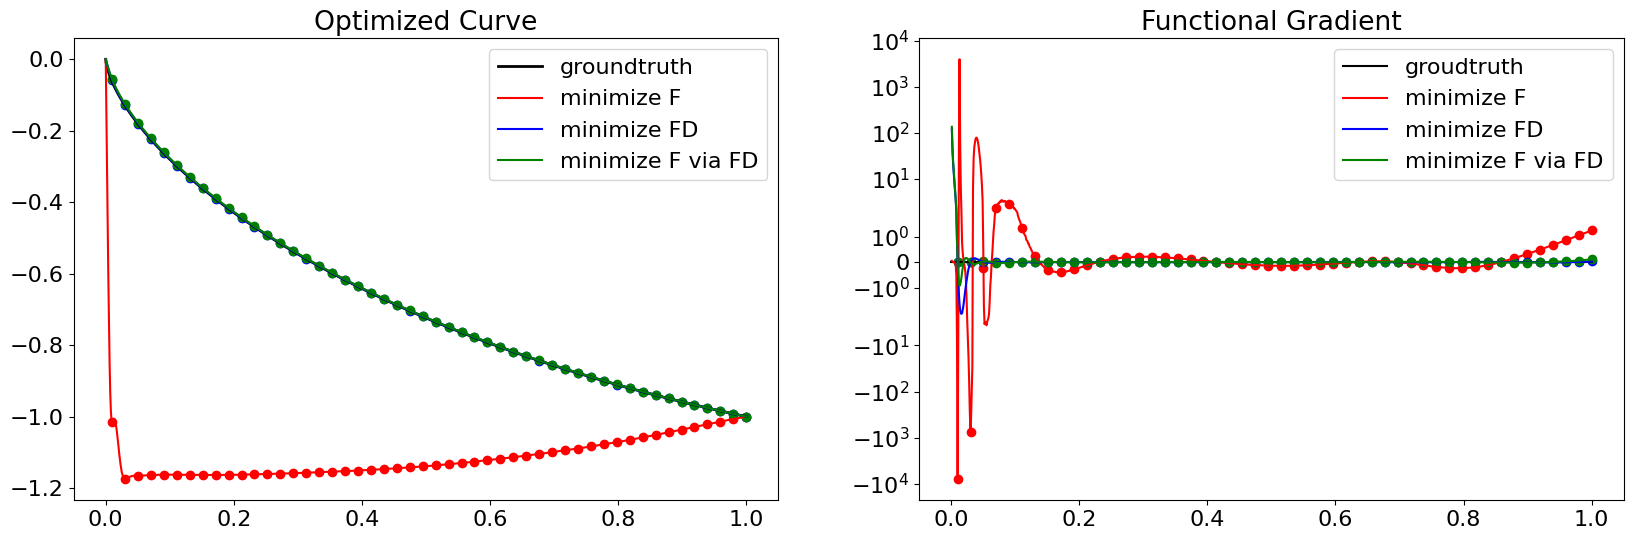

In [11]:
plt.rcParams.update({'font.size': 16})

# function used for computing the ground truth
def cycloid(x2=1, y2=1, N=100):
  from scipy.optimize import newton

  def f(theta):
    return y2 / x2 - (1 - np.cos(theta)) / (theta - np.sin(theta))

  theta2 = newton(f, np.pi / 2)
  R = y2 / (1 - np.cos(theta2))
  theta = np.linspace(0, theta2, N)
  x = R * (theta - np.sin(theta))
  y = R * (1 - np.cos(theta))
  return x, y

# before plotting, we first generate the ground truth
x, y = cycloid()
y = -y

def plot(ax, f, fd, f_via_fd, title, yl, yu, cycloid=True):
    dense_grids = jnp.linspace(0., 1., 1000)
    if cycloid:
      line, = ax.plot(x, y, color="black", linewidth=2)
      line.set_label("groundtruth")
      # ax.scatter(x, y, marker="o", color="black")
    else:
      line, = ax.plot(x, jnp.zeros_like(x), color="black")
      line.set_label("groudtruth")
    line, = ax.plot(dense_grids, jax.vmap(f)(dense_grids), color="red")
    line.set_label("minimize F")
    ax.scatter(nodes, jax.vmap(f)(nodes), marker="o", color="red")
    line, = ax.plot(dense_grids, jax.vmap(fd)(dense_grids), color="blue")
    line.set_label("minimize FD")
    ax.scatter(nodes, jax.vmap(fd)(nodes), marker="o", color="blue")
    line, = ax.plot(dense_grids, jax.vmap(f_via_fd)(dense_grids), color="green")
    line.set_label("minimize F via FD")
    ax.scatter(nodes, jax.vmap(f_via_fd)(nodes), marker="o", color="green")
    ax.set_title(title)
    ax.legend()
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot(
    ax[0], sol_F, sol_FD, sol_F_via_FD,
    "Optimized Curve", -1.1, 0.1
)
plot(ax[1], grad_F, grad_FD, grad_F_via_FD, "Functional Gradient", -15, 10, False)
ax[1].set_yscale("symlog")
plt.savefig("brachistochrone.pdf")